In [1]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import zipfile


In [2]:
DATA_DIR = '../input/'
train_image = os.path.join(DATA_DIR, 'train-data/image')
train_label = os.path.join(DATA_DIR, 'train-data/label')
unlabeled_image = os.path.join(DATA_DIR, 'unlabeled-data')
test_image = os.path.join(DATA_DIR, 'test-data/image')


In [3]:
# img = np.asarray(Image.open('./example_images/images/vyqade.JPG'))
# label = np.load('./example_images/labels/vyqade_gt.npy')
# print(f'Shape of image: {img.shape}')
# print(f'Shape of label: {label.shape}')

In [4]:
# Custom Dataset Class
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None, label_transform=None, has_labels=True):
        self.root_dir = root_dir
        self.image_folder = os.path.join(root_dir, 'image')
        self.label_folder = os.path.join(root_dir, 'label')
        self.image_filenames = [file for file in os.listdir(self.image_folder) if file.endswith(('.JPG','.jpg','.jpeg', '.JPEG'))]
        self.transform = transform
        self.label_transform = label_transform
        self.has_labels = has_labels
        
    def __len__(self):
        return len(self.image_filenames)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.image_folder, self.image_filenames[idx])
        image_id = os.path.splitext(self.image_filenames[idx])[0]  # Extract ID without extension
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        if self.has_labels:
            label_name = os.path.join(self.label_folder, f'{image_id}_gt.npy')
            label = np.load(label_name)
            label = Image.fromarray(label.astype(np.uint8))  # Convert to PIL image for resizing
            if self.label_transform:
                label = self.label_transform(label)
            label = torch.squeeze(label, 0)  # Remove the channel dimension from label
            return image, label
        else:
            return image, image_id
        

# Define the transformations with resizing
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # Resize to a reasonable size
    transforms.ToTensor()
])

label_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),  # Use nearest for segmentation labels
    transforms.ToTensor()
])

# Create the dataset and dataloaders
train_dir = '../input/train-data'
train_dataset = ImageDataset(train_dir, transform=transform, label_transform=label_transform, has_labels=True)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [5]:
# Model setup
device = torch.device('cuda')
num_classes = 4  # Change this to the number of classes in your dataset

model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))  # Adjusting final layer for the number of classes

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 92.0MB/s] 


In [6]:
# torch.cuda.empty_cache()


In [7]:
# Training loop
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)['out']
        
        # Ensure labels are of type long for CrossEntropyLoss
        labels = labels.long()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}")

Epoch [1/10], Loss: 0.8258012993769213
Epoch [2/10], Loss: 0.23284656622193076
Epoch [3/10], Loss: 0.08023352616212585
Epoch [4/10], Loss: 0.03784669681706212
Epoch [5/10], Loss: 0.02673312530598857
Epoch [6/10], Loss: 0.017607504755935886
Epoch [7/10], Loss: 0.014068366875025358
Epoch [8/10], Loss: 0.010806991126049648
Epoch [9/10], Loss: 0.009048561904240738
Epoch [10/10], Loss: 0.008187069472941485


In [8]:
# Save the model
torch.save(model.state_dict(), 'deeplabv3_model.pth')

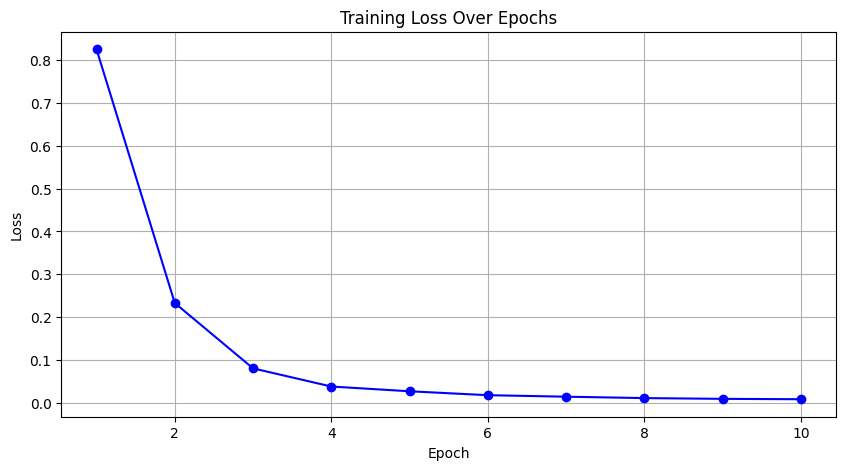

In [9]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), losses, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [14]:
# Load the model weights for evaluation
# model.load_state_dict(torch.load('../input/deeplabv3_init/pytorch/inputresized/1/deeplabv3_model.pth'))
model.load_state_dict(torch.load('deeplabv3_model.pth'))
model.eval()

# Create the test dataset and dataloader
test_dir = '../input/test-data'
test_dataset = ImageDataset(test_dir, transform=transform, has_labels=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Directory to save predictions
output_dir = './predictions2'
os.makedirs(output_dir, exist_ok=True)

In [ ]:
# Clear GPU cache before evaluation
# torch.cuda.empty_cache()

In [15]:
with torch.no_grad():
    for images, image_ids, original_sizes in test_loader:
        print(f"Image shape: {images.shape}")  # Print the shape of the input image
        images = images.to(device)
        
        outputs = model(images)['out']
        
        print(f"Output shape: {outputs.shape}")  # Print the shape of the output
        
        # Resize outputs to the original image size
        outputs = torch.nn.functional.interpolate(outputs, size=original_sizes, mode='bilinear', align_corners=False)
        
        # Generate the prediction mask
        predictions = outputs.argmax(1).cpu().numpy()
        
        # Save the prediction mask
        for i, prediction in enumerate(predictions):
            prediction_file = f'{image_ids[i]}_pred.npy'
            np.save(os.path.join(output_dir, prediction_file), prediction)

ValueError: not enough values to unpack (expected 3, got 2)

In [13]:
# Function to zip the predictions
def zip_predictions(output_dir, zip_filename):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files in os.walk(output_dir):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                           os.path.join(output_dir, '..')))

# Name of the zip file
zip_filename = 'predictions.zip'

# Create the zip file
zip_predictions(output_dir, zip_filename)

print(f"Predictions have been zipped into {zip_filename}")

Predictions have been zipped into predictions.zip
